## Code Generation and Review Workflow

In [2]:
from dotenv import load_dotenv

# Load env vars
load_dotenv()

True

In [3]:
from langchain_groq import ChatGroq

# Initialize Llama3 model
llm = ChatGroq(model="llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7f3e4c7842e0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f3e4c785690>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [4]:
from typing_extensions import TypedDict

# Graph state
class State(TypedDict):
    code: str
    prompt: str
    testcases: str
    reviewed_code:str
    code_approved:str


In [5]:
# Define nodes
def generate_code(state: State):
    """LLM call to generate code from the given prompt."""
    result = llm.invoke(f"Write a programming code for {state['prompt']}")
    return {"code": result.content}

def write_testcases(state: State):
    """LLM call to write the test cases for the generated code."""
    result = llm.invoke(f"Write the test cases for the following code: {state['code']}")
    return {"testcases": result.content}

def code_reviewer(state: State):
    """ LLM to review the generated code and provide efficiency suggestions."""
    result = llm.invoke(f"Make this code more efficient by giving suggestions with suggestions: {state['code']}")
    result = llm.invoke(f"Act like a senior developer, review the code and suggest improvements for efficiency: {state['code']}")
    return {"reviewed_code": result.content}

def code_evaluator(state: State):
    """LLM call to reviewing the code and providing approval status."""
    result = llm.invoke(f"Act like a project manager, review the following code and provide an approval status ('Pass' or 'Fail'): {state['reviewed_code']}")
    return {"code_approved": result.content}

def check_approved(state: State):
    """Evaluate the approval status of the code"""

    if "approved" in state["code_approved"].lower() or "pass" in state["code_approved"].lower():
        return "Pass"
    return "Fail"

In [22]:
from langgraph.graph import StateGraph, START, END

# Build workflow
workflow_builder = StateGraph(State)

# Add nodes
workflow_builder.add_node("generate_code", generate_code)
workflow_builder.add_node("write_testcases", write_testcases)
workflow_builder.add_node("code_reviewer", code_reviewer)
workflow_builder.add_node("code_evaluator", code_evaluator)

# Add edges to connect nodes
workflow_builder.add_edge(START, "generate_code")
workflow_builder.add_edge("generate_code", "write_testcases")
workflow_builder.add_edge("write_testcases", "code_reviewer")

workflow_builder.add_conditional_edges(
    "code_evaluator", 
    check_approved, 
    {"Fail": "generate_code", "Pass": END}
)
workflow_builder.add_edge("code_reviewer", "code_evaluator")
workflow_builder.add_edge("code_evaluator", END)

# Compile the workflow
workflow = workflow_builder.compile()

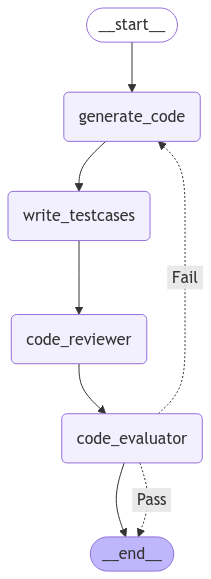

In [23]:
from IPython.display import Image, display

display(Image(workflow.get_graph().draw_mermaid_png()))

In [24]:
# Invoke the workflow
result = workflow.invoke({"prompt": "Write a Python function to calculate the factorial of a number."})
result

{'code': "Here is a Python function to calculate the factorial of a number:\n```\ndef factorial(n):\n    if n == 0:\n        return 1\n    else:\n        return n * factorial(n-1)\n```\nThis is a recursive function, which means it calls itself to calculate the factorial. The base case is when `n` is 0, in which case the function returns 1 (since the factorial of 0 is defined to be 1). Otherwise, the function calls itself with `n-1` as the argument, and multiplies the result by `n`.\n\nHere's an example usage:\n```\n>>> factorial(5)\n120\n```\nThis would calculate the factorial of 5, which is 5 * 4 * 3 * 2 * 1 = 120.\n\nYou can also write an iterative version of the function using a loop:\n```\ndef factorial(n):\n    result = 1\n    for i in range(1, n+1):\n        result *= i\n    return result\n```\nThis function uses a loop to calculate the factorial, starting from 1 and multiplying the result by each integer up to `n`.\n\nBoth of these functions will work correctly for positive inte

In [25]:
# Check and display the generated code
if 'code' in result:
    print("------ GENERATED CODE ------")
    print(result['code'])
else:
    print("\nNO CODE GENERATED FOR THE GIVEN PROMPT.")

------ GENERATED CODE ------
Here is a Python function to calculate the factorial of a number:
```
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)
```
This is a recursive function, which means it calls itself to calculate the factorial. The base case is when `n` is 0, in which case the function returns 1 (since the factorial of 0 is defined to be 1). Otherwise, the function calls itself with `n-1` as the argument, and multiplies the result by `n`.

Here's an example usage:
```
>>> factorial(5)
120
```
This would calculate the factorial of 5, which is 5 * 4 * 3 * 2 * 1 = 120.

You can also write an iterative version of the function using a loop:
```
def factorial(n):
    result = 1
    for i in range(1, n+1):
        result *= i
    return result
```
This function uses a loop to calculate the factorial, starting from 1 and multiplying the result by each integer up to `n`.

Both of these functions will work correctly for positive integers, bu

In [26]:
# Check and display the generated test cases
if "testcases" in result:
    print("------ TEST CASES ------")
    print(result['testcases'])
else:
    print("\nNO TEST CASES FOUND.")

------ TEST CASES ------
Here are some test cases for the recursive and iterative factorial functions:

**Recursive Function**

1. `factorial(0)`: Expected output: 1 (base case)
2. `factorial(1)`: Expected output: 1 (should return 1)
3. `factorial(2)`: Expected output: 2 (should return 2)
4. `factorial(3)`: Expected output: 6 (should return 6)
5. `factorial(4)`: Expected output: 24 (should return 24)
6. `factorial(5)`: Expected output: 120 (should return 120)
7. `factorial(6)`: Expected output: 720 (should return 720)
8. `factorial(7)`: Expected output: 5040 (should return 5040)
9. `factorial(-1)`: Expected output: Error (should raise an error, as `n` is negative)
10. `factorial(3.5)`: Expected output: Error (should raise an error, as `n` is a non-integer)

**Iterative Function**

1. `factorial(0)`: Expected output: 1 (base case)
2. `factorial(1)`: Expected output: 1 (should return 1)
3. `factorial(2)`: Expected output: 2 (should return 2)
4. `factorial(3)`: Expected output: 6 (should 

In [27]:
# Check and display the approval status of the code
if "code_approved" in result:
    print("------ APPROVED CODE ------")
    print(result["code_approved"])
else:
    print("\nCODE HAS NOT BEEN APPROVED.")

------ APPROVED CODE ------
**Approval Status:** Pass

**Reasoning:**

The code review highlights several areas for improvement, and the updated versions of the recursive and iterative functions address the issues effectively. The use of memoization in the recursive function reduces the number of function calls and improves performance, while the iterative function is optimized for efficiency.

The built-in `math.factorial` function is the most efficient and recommended way to calculate the factorial, and it's great that it's included as an option.

The additional suggestions provided are also valuable, as they enhance the code's robustness, readability, and maintainability. Error handling, docstrings, and testing are essential for ensuring the code's quality and reliability.

Overall, I'm satisfied with the code and the suggested improvements. The updated functions are efficient, readable, and well-maintained, and the inclusion of the built-in `math.factorial` function provides an alt